In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import utils
from utils.get_nn_models import *
from utils.sbiutils import *
from utils.torchutils import *
from inference.base import *
import torch
import pickle
import seaborn as sns
from inference.snpe.snpe_c import SNPE_C as SNPE
# from networks.summary_nets import LotkaSummary

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)
        
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def _deriv(x, t, alpha, beta, gamma, delta):
    """Helper function for scipy.integrate.odeint."""

    X, Y = x
    dX = alpha*X - beta*X*Y
    dY = -gamma*Y + delta*X*Y
    return dX, dY


def lotka_volterra(theta, X0=30, Y0=1, T=20, flatten=True):
    """Runs a Lotka-Volterra simulation for T time steps and returns `subsample` evenly spaced
    points from the simulated trajectory, given contact parameters `theta`.
    See https://arxiv.org/pdf/2101.04653.pdf, Benchmark Task T.10.

    Parameters
    ----------
    theta       : np.ndarray of shape (2,)
        The 2-dimensional vector of disease parameters.
    X0          : float, optional, default: 30
        Initial number of prey species.
    Y0          : float, optional, default: 1
        Initial number of predator species.
    T           : T, optional, default: 20
        The duration (time horizon) of the simulation.
    subsample   : int or None, optional, default: 10
        The number of evenly spaced time points to return. If None,
        no subsampling will be performed and all T timepoints will be returned.
    flatten     : bool, optional, default: True
        A flag to indicate whather a 1D (`flatten=True`) or a 2D (`flatten=False`)
        representation of the simulated data is returned.
    rng         : np.random.Generator or None, default: None
        An optional random number generator to use.
    Returns
    -------
    x : np.ndarray of shape (subsample, 2) or (subsample*2,) if `subsample is not None`,
        otherwise shape (T, 2) or (T*2,) if `subsample is None`.
        The time series of simulated predator and pray populations
    """
    nSamples = 100
    
    theta = theta[0].detach().numpy()
    
    Y = torch.zeros(size=(nSamples, T*2))
    # Use default RNG, if None specified
    for i in range(nSamples):
        rng = np.random.default_rng()

        # Create vector (list) of initial conditions
        x0 = X0, Y0

        # Unpack parameter vector into scalars
        alpha, beta, gamma, delta = theta

        # Prepate time vector between 0 and T of length T
        t_vec = np.linspace(0, T, T)

        # Integrate using scipy and retain only infected (2-nd dimension)
        pp, info = odeint(_deriv, x0, t_vec, args=(alpha, beta, gamma, delta), full_output=True)

        # Ensure minimum count is 0, which will later pass by log(0 + 1)
        pp[pp < 0] = 0

        # Add noise, decide whether to flatten and return
        x = rng.lognormal(np.log1p(pp), sigma=0.1)
        if flatten:
            Y[i] = torch.tensor(x.flatten())
    return Y

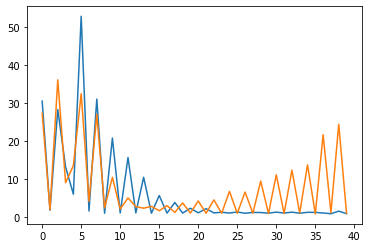

In [97]:
theta = torch.tensor([[0.2,0.05,0.5,0.1]])
plt.plot(range(40), lotka_volterra(theta)[1])
theta = torch.tensor([[0.2,0.05,1,0.1]])
plt.plot(range(40), lotka_volterra(theta)[1])

In [3]:
# prior = utils.BoxUniform(low=torch.exp(-1*torch.ones(4)), high=torch.exp(1*torch.ones(4)))

# mean = torch.tensor([-0.125, -3, -0.125, -3]).to(device)
# loc = torch.tensor([0.5, 0.5, 0.5, 0.5]).to(device)
# prior = torch.distributions.log_normal.LogNormal(mean,loc)
low = torch.tensor([0.1, 0.01, 0.1, 0.01]).to(device)
high = torch.tensor([2., 0.15, 2., 0.15]).to(device)
prior = torch.distributions.uniform.Uniform(low, high)
num_simulations = 10000

In [4]:
theta, x = simulate_for_sbi(lotka_volterra, prior, num_simulations=num_simulations)
x = x.reshape(num_simulations, 100, 40).to(device)
theta = theta.to(device)
np.save("data/lotka_x_10000_uni.npy", x)
np.save("data/lotka_theta_10000_uni.npy", theta)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [5]:
x = torch.tensor(np.load("data/lotka_x_10000_uni.npy")).to(device)
# x_corrupted = torch.tensor(np.load("x_corrupted.npy")).to(device)
theta = torch.tensor(np.load("data/lotka_theta_10000_uni.npy")).to(device)
print("x shape", x.shape)
print("theta shape", theta.shape)

x shape torch.Size([10000, 100, 40])
theta shape torch.Size([10000, 4])


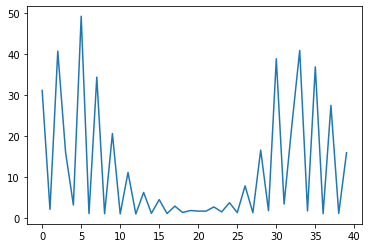

In [157]:
plt.plot(range(40), x[1011][2])

In [179]:
class LotkaSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(LotkaSummary, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.input_size = input_size
#         self.lstm = nn.LSTM(20, 8, 1, batch_first=True)

        self.conv = nn.Sequential(nn.Conv1d(self.input_size, self.hidden_dim, 3, 2),
                                  nn.Conv1d(self.hidden_dim, self.hidden_dim, 3, 2),
                                  nn.Conv1d(self.hidden_dim, self.hidden_dim, 3, 3),
                                  nn.AvgPool1d(3))

    def forward(self, Y):
        batch_size = Y.size(0)
        
        embeddings_conv = self.conv(Y.reshape(-1, 1, 40)).reshape(-1, 100, 10)
#         print(embeddings_conv.shape)
#         hidden, c = self.init_hidden(100*batch_size)
#         out, (embeddings_lstm, c) = self.lstm(embeddings_conv.reshape(100*batch_size, 9, self.hidden_dim), (hidden, c))
#         print(embeddings_lstm.shape)
#         embeddings_lstm = embeddings_lstm.reshape(batch_size, 100, 8)
  
#         stat_lstm = torch.mean(embeddings_lstm, dim=1)
        
#         .reshape(-1, 100, 4)
        stat_conv = torch.mean(embeddings_conv, dim=1)
        
#         return embeddings_lstm, stat_lstm
        return embeddings_conv, stat_conv
        

    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(1, batch_size, 8)
        c = torch.zeros(1, batch_size, 8)
        return hidden, c

In [6]:
class LotkaSummary(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(LotkaSummary, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = 1
        self.lstm = nn.LSTM(1, self.hidden_dim, self.num_layers, batch_first=True)

        self.conv = nn.Sequential(nn.Conv1d(self.input_size, self.hidden_dim, 3, 2),
                                  nn.Conv1d(self.hidden_dim, self.hidden_dim, 3, 2),
                                  nn.Conv1d(4, self.hidden_dim, 3, 3),
                                  nn.AvgPool1d(3))
        self.fc = nn.Linear(self.hidden_dim, 8)

    def forward(self, Y):
        current_device = Y.device
        batch_size = Y.size(0)
#         print(Y.shape)
#         embeddings_conv = self.conv(Y.reshape(-1, 1, 40)).reshape(-1, 100, 4)
#         stat_conv = torch.mean(embeddings_conv, dim=1)
#         print(stat_conv.shape)

        hidden, c = self.init_hidden(100*batch_size, current_device)
        out, (embeddings_lstm, c) = self.lstm(Y.reshape(100*batch_size, 40, 1), (hidden, c))
#         print(embeddings_lstm.shape)
        embeddings_lstm = embeddings_lstm.reshape(batch_size, 100, self.hidden_dim)

        stat_lstm = torch.mean(embeddings_lstm, dim=1)
        out = self.fc(stat_lstm)

#         print(stat_lstm.shape)
#         stat = torch.cat([stat_conv, stat_lstm], dim=1)
        
        return embeddings_lstm, out

    def init_hidden(self, batch_size, current_device):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        c = torch.zeros(1*self.num_layers, batch_size, self.hidden_dim).to(current_device)
        return hidden, c

In [17]:
sum_net_normal = LotkaSummary(input_size=1, hidden_dim=128).to(device)
sum_net_normal(x[:400])[1].shape

torch.Size([400, 8])

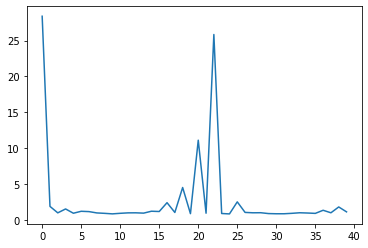

In [98]:
theta_gt = torch.tensor([[1,2,3,1]])

obs = lotka_volterra(theta_gt).to(device)
plt.plot(range(40), obs[3])

In [7]:
sum_net_normal = LotkaSummary(input_size=1, hidden_dim=128).to(device)
neural_posterior_normal = posterior_nn(
    model="maf", 
    embedding_net=sum_net_normal, 
    hidden_features=20, 
    num_transforms=4)
inference_normal = SNPE(prior=prior, density_estimator=neural_posterior_normal, device="cuda:0")
density_estimator_normal = inference_normal.append_simulations(theta, x.unsqueeze(1)).train(corrupt_data_training="none")
posterior_normal = inference_normal.build_posterior(density_estimator_normal)

C:\Users\Daolang Huang\AppData\Roaming\Python\Python39\site-packages\sbi\utils\torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect **no** significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(
C:\Users\Daolang Huang\OneDrive - Aalto University\Projects\Robust SBI\Robust-SBI\utils\user_input_checks.py:428: UserWarning: Mismatch between the device of the data fed to the embedding_net and the device of the embedding_net's weights. Fed data has device 'cpu' vs embedding_net weights have device 'cuda:0'. Automatically switching the embedding_net's device to 'cpu', which could otherwise be done manually using the line `embedding_net.to('cpu')`.
  warnings.warn(


 Neural network successfully converged after 367 epochs.

<AxesSubplot:>

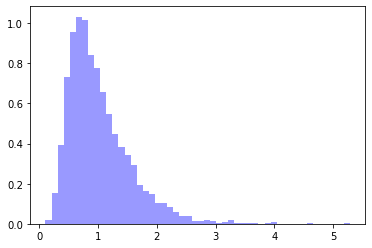

In [114]:
sns.distplot(theta[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\rnn.py:761: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\RNN.cpp:926.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


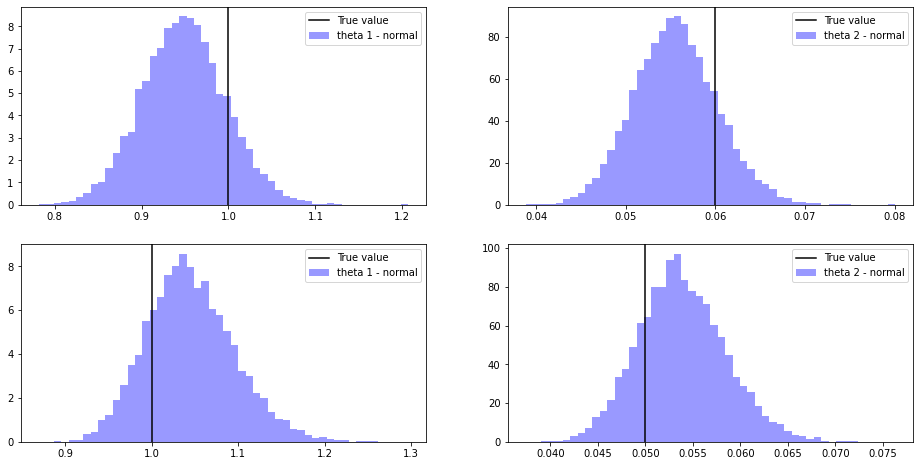

In [8]:
theta_gt = torch.tensor([[1,0.06,1,0.05]])

obs = lotka_volterra(theta_gt).to(device)

post_samples_normal = posterior_normal.sample((10000,), x=obs.reshape(1, 100, 40))
# post_samples_robust = posterior_robust.sample((10000,), x=obs.reshape(1, 100, 40))

plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
plt.axvline(x=theta_gt[0][0],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 0].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
# sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(2, 2, 2)
plt.axvline(x=theta_gt[0][1],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 1].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
# sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.subplot(2, 2, 3)
plt.axvline(x=theta_gt[0][2],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 2].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 1 - normal")
# sns.distplot(post_samples_robust[:, 0].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 1 - robust")
plt.legend()

plt.subplot(2, 2, 4)
plt.axvline(x=theta_gt[0][3],ls="-",c="black", label="True value")
sns.distplot(post_samples_normal[:, 3].cpu().numpy(), color='blue', kde=False, norm_hist=True, label="theta 2 - normal")
# sns.distplot(post_samples_robust[:, 1].cpu().numpy(), color='red', kde=False, norm_hist=True, label="theta 2 - robust")
plt.legend()

plt.show()

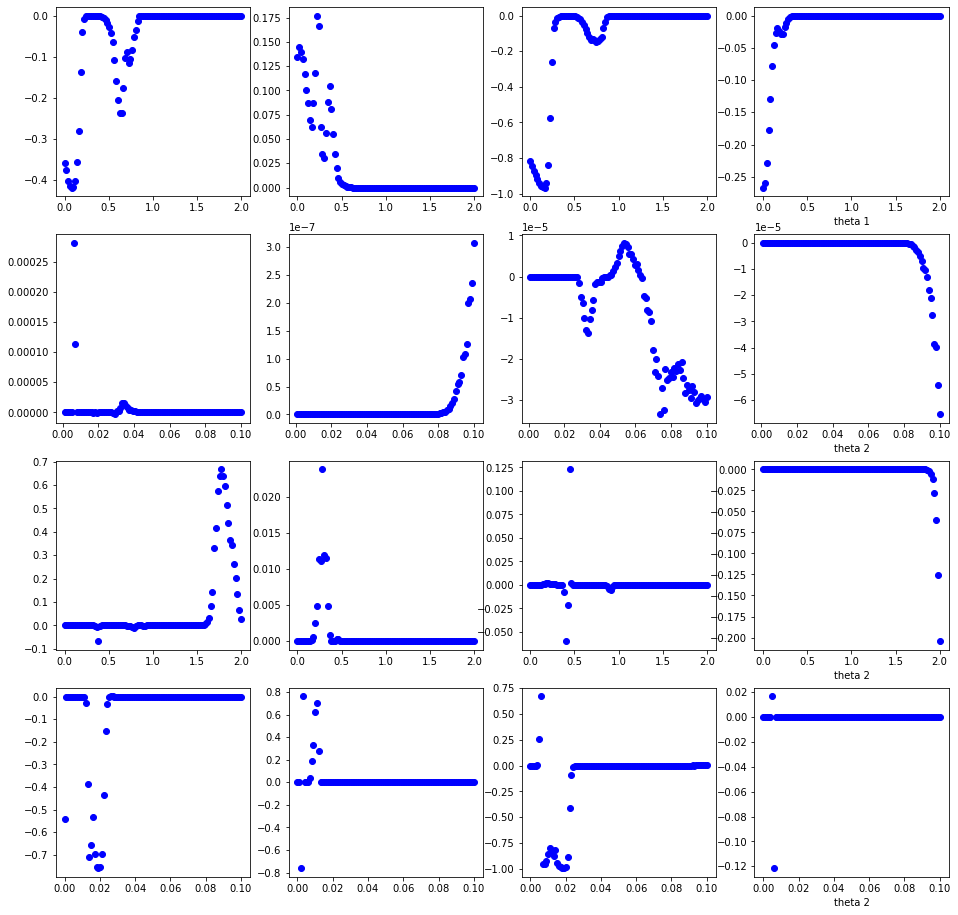

In [166]:
n_samples = 100

theta_1 = np.linspace(0, 2, 100)
theta_2= np.linspace(0, 0.1, 100)
theta_3 = np.linspace(0, 2, 100)
theta_4= np.linspace(0, 0.1, 100)
theta_1_unchange = np.repeat(1, 100)
theta_2_unchange = np.repeat(0.05, 100)
theta_3_unchange = np.repeat(1, 100)
theta_4_unchange = np.repeat(0.05, 100)

thetas_1 = torch.tensor(np.stack((theta_1, theta_2_unchange, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_2 = torch.tensor(np.stack((theta_1_unchange, theta_2, theta_3_unchange, theta_4_unchange), axis=-1))
thetas_3 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3, theta_4_unchange), axis=-1))
thetas_4 = torch.tensor(np.stack((theta_1_unchange, theta_2_unchange, theta_3_unchange, theta_4), axis=-1))

hidden_1_normal = np.zeros((len(thetas_1), 8))
hidden_2_normal = np.zeros((len(thetas_2), 8))
hidden_3_normal = np.zeros((len(thetas_3), 8))
hidden_4_normal = np.zeros((len(thetas_4), 8))
# hidden_1_robust = np.zeros((len(thetas_1), 4))
# hidden_2_robust = np.zeros((len(thetas_2), 4))

for i in range(len(thetas_1)):
    obs_1 = lotka_volterra(thetas_1[i].reshape(-1, 4)).reshape(1, n_samples, 40).to(device)
    obs_2 = lotka_volterra(thetas_2[i].reshape(-1, 4)).reshape(1, n_samples, 40).to(device)
    obs_3 = lotka_volterra(thetas_3[i].reshape(-1, 4)).reshape(1, n_samples, 40).to(device)
    obs_4 = lotka_volterra(thetas_4[i].reshape(-1, 4)).reshape(1, n_samples, 40).to(device)

    hidden_1_normal[i] = sum_net_normal(obs_1)[1].reshape(-1).cpu().detach().numpy()
    hidden_2_normal[i] = sum_net_normal(obs_2)[1].reshape(-1).cpu().detach().numpy()
    hidden_3_normal[i] = sum_net_normal(obs_3)[1].reshape(-1).cpu().detach().numpy()
    hidden_4_normal[i] = sum_net_normal(obs_4)[1].reshape(-1).cpu().detach().numpy()
#     hidden_1_robust[i] = sum_net_robust(obs_1)[1].reshape(-1).cpu().detach().numpy()
#     hidden_2_robust[i] = sum_net_robust(obs_2)[1].reshape(-1).cpu().detach().numpy()
    

plt.figure(figsize=(16,16))
plt.subplot(4, 4, 1)
plt.scatter(theta_1, hidden_1_normal[:, 0], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 0], color="red")
plt.subplot(4, 4, 2)
plt.scatter(theta_1, hidden_1_normal[:, 1], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 1], color="red")
plt.subplot(4, 4, 3)
plt.scatter(theta_1, hidden_1_normal[:, 2], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 2], color="red")
plt.subplot(4, 4, 4)
plt.scatter(theta_1, hidden_1_normal[:, 3], color="blue")
# plt.scatter(theta_1, hidden_1_robust[:, 3], color="red")
plt.xlabel("theta 1")

plt.subplot(4, 4, 5)
plt.scatter(theta_2, hidden_2_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 6)
plt.scatter(theta_2, hidden_2_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 7)
plt.scatter(theta_2, hidden_2_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 8)
plt.scatter(theta_2, hidden_2_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 9)
plt.scatter(theta_3, hidden_3_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 10)
plt.scatter(theta_3, hidden_3_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 11)
plt.scatter(theta_3, hidden_3_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 12)
plt.scatter(theta_3, hidden_3_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")

plt.subplot(4, 4, 13)
plt.scatter(theta_4, hidden_4_normal[:, 0], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 0], color="red")
plt.subplot(4, 4, 14)
plt.scatter(theta_4, hidden_4_normal[:, 1], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 1], color="red")
plt.subplot(4, 4, 15)
plt.scatter(theta_4, hidden_4_normal[:, 2], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 2], color="red")
plt.subplot(4, 4, 16)
plt.scatter(theta_4, hidden_4_normal[:, 3], color="blue")
# plt.scatter(theta_2, hidden_2_robust[:, 3], color="red")
plt.xlabel("theta 2")
plt.show()